In [1]:
import os
import pandas as pd
#import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import time
from testWN import testWN as twm
import wntr
import wntr.network.controls as controls
import wntr.metrics.economic as economics
import pdb
import pickle
import random

In [2]:
%matplotlib notebook

# Water Network data loading

/Applications/anaconda3/lib/python3.7/site-packages/wntr/epanet/io.py:2085: UserWarning: Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


<IPython.core.display.Javascript object>


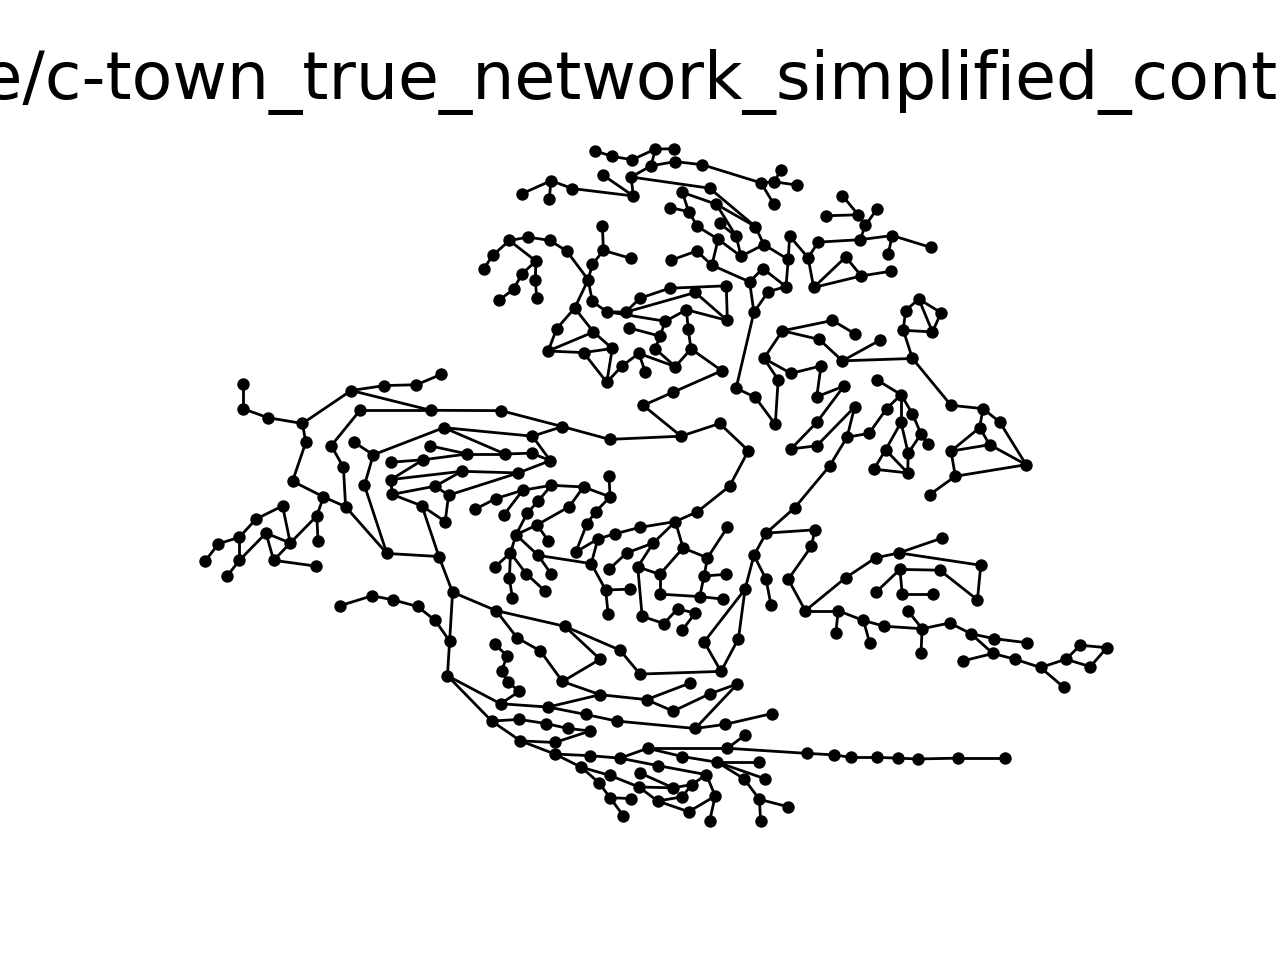

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [3]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'

ctown = twm(inp_file)

# plt.figure()

# %%
# Graphical representation of the network
plt.rcParams.update({'font.size': 20})
wntr.graphics.plot_network(ctown.wn, title=ctown.wn.name, node_labels=False, link_labels=False, directed=False)
fig = mpl.pyplot.gcf()
mpl.rcParams.update(mpl.rcParamsDefault)

plt.show()

# Setting up multiple simulations for AI training

In [4]:
# ::: Initializing random seed
random.seed(3)

# ::: Setting up time and water quality options for simulation
nDaysSim = 7
nHoursSim = 24*nDaysSim

ctown.wn.options.time.hydraulic_timestep = 60*15  # 15 min
ctown.wn.options.time.quality_timestep = 60*15  # 15 min
ctown.wn.options.time.report_timestep = 60*15
ctown.wn.options.quality.mode = 'AGE'
ctown.wn.options.results.energystr = True

controlTvary =3 # Number of hours for varying controls

# ::: Getting tank elevations
tankEl =[]
for i, name in ctown.wn.tanks():
    tankEl.append(name.elevation)
np.array(tankEl)
nodeNames = ctown.getNodeName()

# ::: Setting upper and lower bounds to control elements
control_components = ctown.wn.pump_name_list + ctown.wn.valve_name_list
min_control = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.]) # Lower bondary for controls
max_control = np.array([2., 2., 2., 2., 2., 600.0, 600.0, 600.0, 70. ]) # Upper bondary for controls

# Setting up dataframe for saving link settings
results_setting=pd.DataFrame(columns=control_components)

# ::: Running multiple simulations
for i in range(150): # Number of simulations
    start_time = time.time()
    print(i)
    
    # ::: Generating random initial states (tank levels)
    for k, name in ctown.wn.tanks():
        name.init_level =random.uniform(name.min_level, name.max_level)

    # ::: Generating random demands
    # Scaling
    ctown.randomlyScaleMultipliers(0.1)  # Input is the maximum possible percentage of change for each pattern value
    #
    # Shifting
    ctown.randomlyShiftMultipliers(3)  # Input is the maximum time shift allowed (in hours)

    # ::: Generating initial random controls
    control_vector = np.zeros(len(min_control))
    for el in range(len(control_vector)):
        control_vector[el] = random.uniform(min_control[el], max_control[el])

    # ::: Running the simulation
    for t in range(nHoursSim): # Iterate over simulation steps

        # ::: Randomly changing controls every few simulation steps
        if (t % controlTvary):
                temp=np.random.randint(1,len(min_control), size = np.int(np.floor(len(min_control)/2)))
                temp=np.unique(temp)   
                for nControl in range(len(temp)):
                    control_vector[temp[nControl]] = random.uniform(min_control[temp[nControl]], max_control[temp[nControl]])
        # Add controls
        for j in range(len(control_components)): # Iterate over controls
            currComp = ctown.wn.get_link(control_components[j])
            cond = controls.SimTimeCondition(ctown.wn, None,t*3600)
            act = controls.ControlAction(currComp, 'setting', control_vector[j])
            ctrl = controls.Control(cond,act, name=control_components[j])
            if np.isin(control_components[j], ctown.wn.control_name_list):
                ctown.wn.remove_control(control_components[j])
            ctown.wn.add_control(control_components[j], ctrl)

        # ::: Run the simulation for the next time step
        ctown.wn.options.time.duration = 3600*t
        sim = wntr.sim.EpanetSimulator(ctown.wn)
        results = sim.run_sim()
        results.tankElevations = results.node['head'][nodeNames[0]]-tankEl
        for j in range(len(control_components)):
            #results_setting[control_components[j]][t]=control_vector[j]
            results_setting.at[t,control_components[j]] = control_vector[j]
    
    results.setting = results_setting
        
    # ::: Saving simulation output
    print('Total simulation time: %.3f s' % (time.time()-start_time))
    with open("results_sim_%s.pkl" % i, "wb") as f:
        pickle.dump(results, f)
    

0
Total simulation time: 10.376 s
1
Total simulation time: 10.041 s
